# Self-Driving Car Engineer Nanodegree


## Project: ** Advanced Lane Finding ** 
***
In this project, ...


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

---

## Import Packages

In [85]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline

test_file ='test6.jpg'

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.


The code for this step is contained in the second code cell of the IPython ("P2.ipynb") notebook located in root dir of my project. The output of all camera calibration images are in output_images/camera_cal dir.  

I start by preparing 3D "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained an undistorted image. Then, I perform a perspective transformation to transform the image so that it looks like the actual image without and distortion. Here is an example of original  image, undistort image and warped image.




In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),criteria)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners. Commented out for submission
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

        undist = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite("output_images/camera_undistort/"+fname[11:], undist)
    
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        
        offset = 100 # offset for dst points

        img_size = (img.shape[1],img.shape[0])

        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        img_size = (img.shape[1],img.shape[0])
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

        cv2.imwrite("output_images/camera_warped/"+fname[11:], warped)

        print(fname[11:])        


print (' all done')



calibration15.jpg
calibration20.jpg
calibration3.jpg
calibration7.jpg
calibration2.jpg
calibration18.jpg
calibration14.jpg
calibration11.jpg
calibration19.jpg
calibration17.jpg
calibration12.jpg
calibration16.jpg
calibration10.jpg
calibration6.jpg
calibration9.jpg
calibration8.jpg
calibration13.jpg
 all done


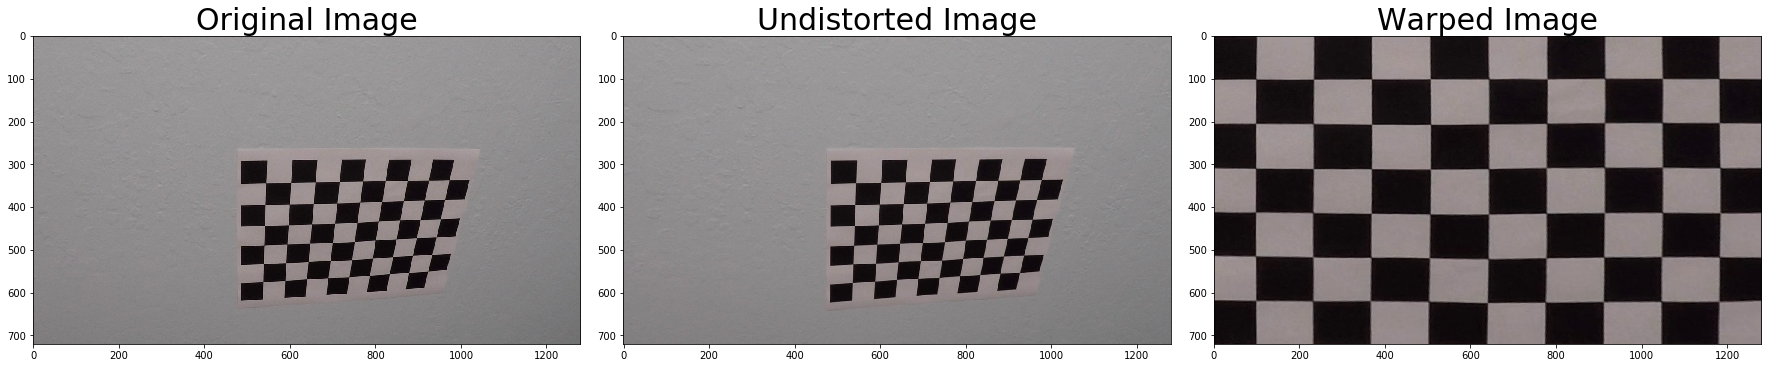

In [3]:
#visulalize for write up
img1 = cv2.imread('camera_cal/calibration10.jpg')
img2 = cv2.imread('output_images/camera_undistort/calibration10.jpg')
img3 = cv2.imread('output_images/camera_warped/calibration10.jpg')

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img2)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(img3)
ax3.set_title('Warped Image', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

This step is similar to what I have done above on camera calibration. I have used Calibration10.jpg as a sample to get the calibration coefficients and apply them to test image and videos. I have defined `undistort()` function for this purpose. Later, this function will be used in the image and video processing pipeline.

An example of applying `undistort()` function on test image (test6.jpg) is generated in the next code segment

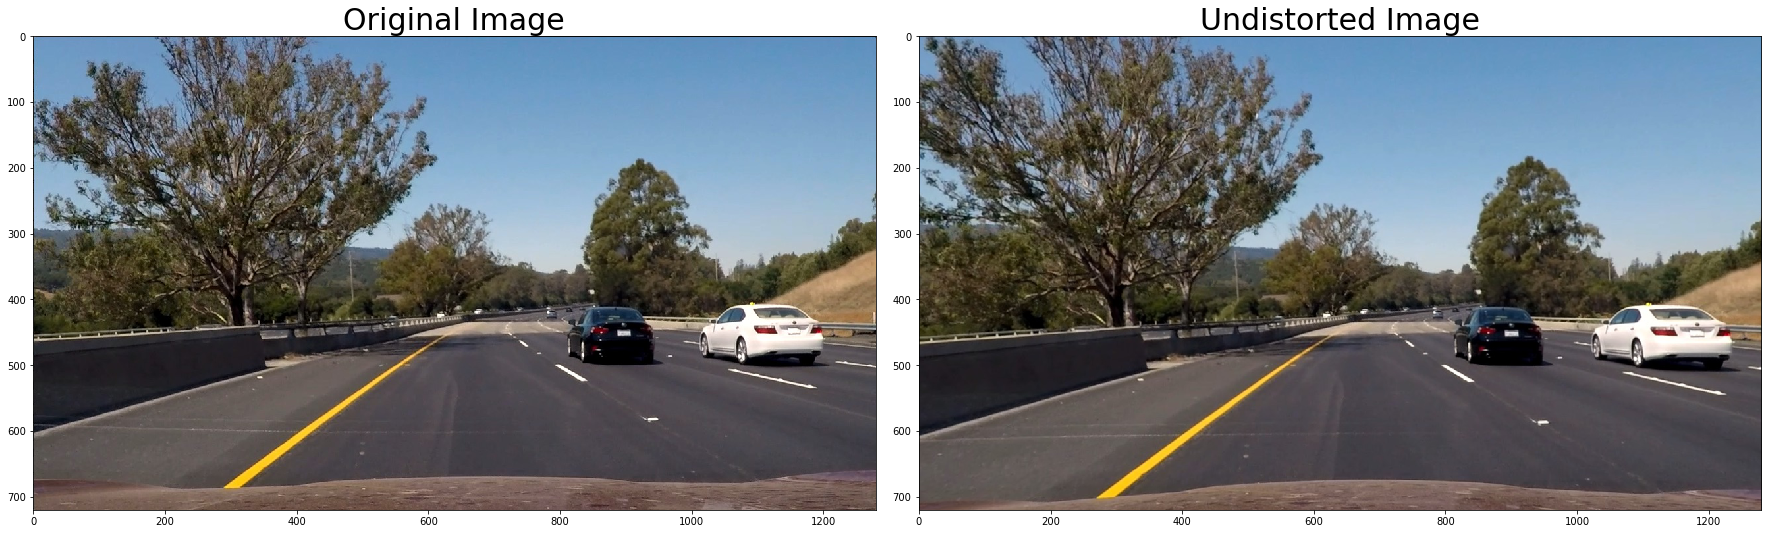

In [86]:
#use a sample image for camera calibration and calculate the coefficients to use in other images and videos
img = cv2.imread('camera_cal/calibration10.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


def undistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist


##Test code to generate images for write up
img2 = cv2.imread('test_images/'+test_file)
cimage = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

undist = undistort(cimage)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cimage)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.


I have done all quizs in the video sections such as sobel operator, mag threshold for gradients and HLS for color. Out of those exercises, it shows S channel shows good promise in converting an image to a thresholded binary image. I have used `hls_select()` function first for this purpose. The threshold I used is (90,255), which gives good result. Here is an example, where I have applied S channel to a distortion corrected test6.jpg image and output image is shown below code segment.

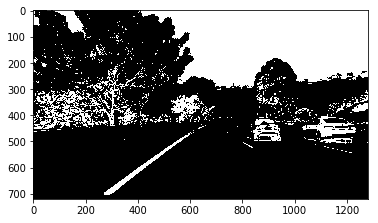

In [87]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    
    S = hls[:,:,2]

    # 3) Return a binary image of threshold result

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1

    #plt.imshow(binary)
    return binary
    

##Test code to generate images for write up
img2 = cv2.imread('test_images/'+test_file)

undist = undistort(img2)
hls_binary = hls_select(undist, thresh=(90, 255))
plt.imshow(hls_binary, cmap='gray')



The above S-channel HLS works for most test images. However it fails on fitting the polynomial for test2.jpg. Therefore, as recommended and given some code snippent in the tuturial, I have combined sobel operator with color transformation. The combined function is called `color_xform`. In the next code segment,  a comparison to apply only S Channel transform and combined transformed on test2.jpg is generated

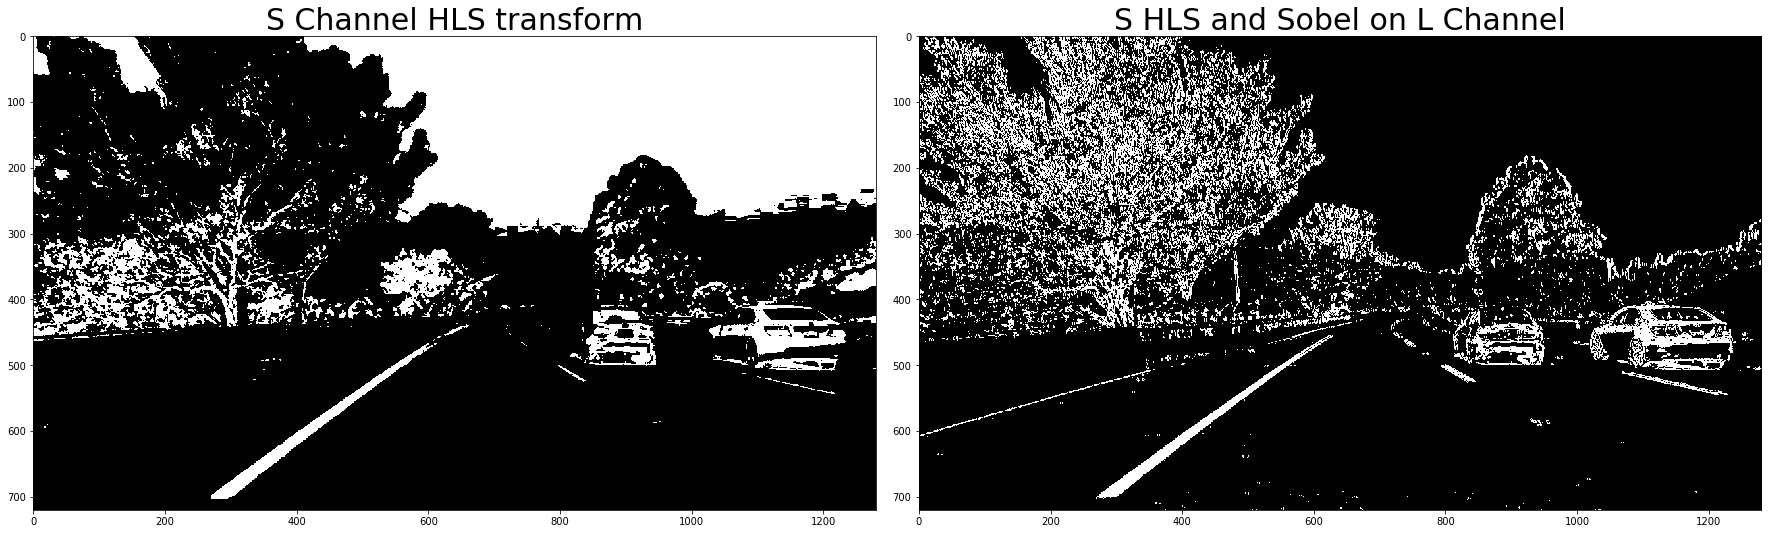

In [88]:
## only S-channel of HLS does not produce good results. It produces image that fails polyfit for test2.jpg
## Here, the plan is to combine S Channel for HLS and L channel for Sobel

#def color_xform(img, s_thresh=(170, 255), sx_thresh=(20, 100)):


def color_xform(img, s_thresh=(170, 255), sx_thresh=(20, 100)):    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)                # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    # Stack each channel  
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary ==1) | (s_binary == 1)] = 1 
    
    return combined_binary
    

##Test code to generate images for write up

img2 = cv2.imread('test_images/'+test_file)

undist = undistort(img2)
result = color_xform(undist, s_thresh=(170,255))
hls_img = hls_select(undist, thresh=(90, 255))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls_img, cmap='gray')
ax1.set_title('S Channel HLS transform', fontsize=30)
ax2.imshow(result, cmap='gray')
ax2.set_title('S HLS and Sobel on L Channel', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

For perspective transform, I have developed  `warper()` function that takes as input image (`img`), computes source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:


```python
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto all test images and its warped counterpart to verify that the lines appear parallel in the warped image. Next code segment shows an example

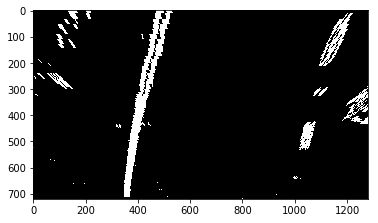

In [89]:
###Function to perform perspective tranform. and also 
##get inverse perspective transform to change warped image back to normal image
## I have removed src and dst from function parameter as I used hard coded value and didn't tune for all variations

def warper(img):

    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Minv for transform back to normal image from warped image
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, Minv

##Test code to generate images for write up

img2 = cv2.imread('test_images/'+test_file)
#img2 = cv2.imread('video_images/original/1533693727.281827.jpg')
undist = undistort(img2)
binary = color_xform(undist)

warped_image, Minv = warper(binary)
plt.imshow(warped_image, cmap='gray')


#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

I follow the sliding window approach from video tutorial to identify lane-line pixels and fit their positions with a polynomial. The functions developed are `find_lane_pixels()` and `fit_polynomial()`. I have applied these to all test images and it works fairly well. I follow the sliding window approach from video tutorial to identify lane-line pixels and fit their positions with a polynomial. The functions developed are `find_lane_pixels()` and `fit_polynomial()`. I have applied these to all test images and it works fairly well. It's a bit challenge and  does not work well for the challenge videos.


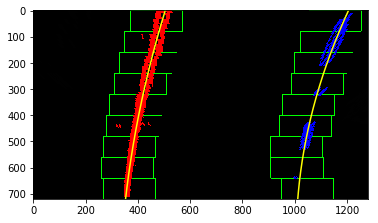

In [90]:
### approximate pixel and meter in x and y dimension using average lane size in USA

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        raise(' met error')
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, show_fit):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    
    left_fit, right_fit = (None, None)

    
    # Fit a second order polynomial to each using `np.polyfit`
    ## If we didn't find pixels, ignore the polyfit
    if (len(leftx) != 0):
        left_fit = np.polyfit(lefty, leftx, 2)
 
    if (len(rightx) != 0):
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # dont show for video
    if (show_fit):
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return  out_img, left_fitx, right_fitx, ploty

#used previous fit and don't run sliding window
def fit_polynomial_without_sliding_window(binary_warped, left_fit, right_fit):

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return  out_img, left_fitx, right_fitx, ploty


##Test code to generate images for write up
img2 = cv2.imread('test_images/'+test_file)
undist = undistort(img2)
#hls_binary = hls_select(undist, thresh=(90, 255))
hls_binary = color_xform(undist)

warped_image, Minv = warper(hls_binary)
out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped_image, True)
plt.imshow(out_img, cmap='gray')


#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

It measures radius for left and right side of the lane. As, the lanes are parallel, I have taken the average out of the two values.


Radius: 919.19m 
Car is:  0.22m from center


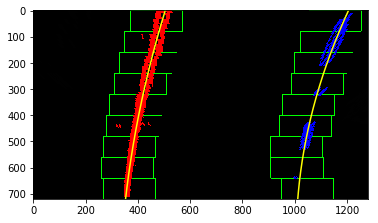

In [91]:
def measure_curvature_real(warped, show_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    img,  left_fitx, right_fitx, ploty = fit_polynomial(warped, show_fit)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    

    #center from road

    left_fit = np.polyfit(ploty, left_fitx, 2)
    right_fit = np.polyfit(ploty, right_fitx, 2)

    if left_fit is not None and right_fit is not None:
        car_pos = warped.shape[1]/2
        cleft_fitx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        cright_fitx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        center_lane = (cleft_fitx + cright_fitx) /2
        center_dist =  (center_lane-car_pos) * xm_per_pix
        
    #returning the average of the two side
    return left_curverad, right_curverad, center_dist


##Test code to generate images for write up

img2 = cv2.imread('test_images/'+test_file)
undist = undistort(img2)
hls_binary = color_xform(undist)

warped_image, Minv = warper(hls_binary)
out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped_image, True)

left_curverad, right_curverad, center_dist = measure_curvature_real(warped_image, False)

radius = (left_curverad+right_curverad)/2
radius = 'Radius: ' + '{:05.2f}'.format(radius) + 'm '
center = 'Car is: ' + '{:5.2f}'.format(center_dist) + 'm from center'

print(radius)
print(center)
plt.imshow(out_img, cmap='gray')


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

Now is the fun part. With the help of the tutorial, I have defined function `map_lane()`, which takes the warped image, fill the area between the detected lane, `un-warp` it and overlay on top of the original image. For this, I needed Minv, which is the inverse perspective transformation, where the `perspective transformation` function (`warper`) is called with `src` and `dst` or used in inverse order. I put both inside `warper()` function instead of calling them separately and it returns `Minv` that will be used in `map_lane()` function. Later code segment shows an example image.


In [35]:
## draw lane on the original image
def map_lane(image, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
            
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result


### Pipeline to process an image

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [] #np.array([0,0], dtype='float')  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
    
    
    def store_fit(self, fit, curvature, center):
         #do we get a good fit, if so add to the list. Otherwise, ignore it
        if fit is not None:
            if self.best_fit is not None :
                # compare this fit with previous best fits
                self.diffs = np.abs(fit-self.best_fit)
            if (self.diffs[0] > 100 or self.diffs[1] > 100 ) and len(self.current_fit) > 0:
                # not good. ignore this one. 
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                #keep last 10
                if len(self.current_fit) > 10:
                    self.current_fit = self.current_fit[len(self.current_fit)-10:]
                #average out     
                self.best_fit = np.average(self.current_fit, axis=0)
        
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)
        

In [45]:
## define the pipeline to process image
## I have applied the above functions one by one to crate image process pipeline

def process_image(image, show_fit=False):
    
    #undistort the image
    undist = undistort(image)

    #color and gradients transformation combined
 
    hls_binary = color_xform(undist)

    #warped image
    warped_image, Minv = warper(hls_binary)

    ##debug code to get image frame from video
    
    #import time
    #ts = time.time()
    #mpimg.imsave("video_images/warped/"+str(ts)+".jpg", warped_image)
    #mpimg.imsave("video_images/binary/"+str(ts)+".jpg", hls_binary)
    #mpimg.imsave("video_images/original/"+str(ts)+".jpg", image)

    ##turned it off as does not get right results yet. Need more investigation
    #if left_line.detected and right_line.detected:
    #    out_img, left_fitx, right_fitx, ploty = fit_polynomial_without_sliding_window(warped_image, left_line.best_fit, right_line.best_fit)
    #else:
    #    out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped_image, show_fit)
       
        
    out_img, left_fitx, right_fitx, ploty = fit_polynomial(warped_image, show_fit)

        
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad, center = measure_curvature_real(warped_image, show_fit)
   
    left_line.store_fit(left_fitx, left_curverad, center)
    
    right_line.store_fit(right_fitx, right_curverad, center)

    
    if (left_line.best_fit is None) or (right_line.best_fit is None):
        return undist
        
    radius = (left_curverad + right_curverad)/2


    ## format text to show on the image/video
    radius = 'Radius: ' + '{:05.2f}'.format(radius) + 'm '
    
    cv2.putText(undist, radius, (100,80), cv2.FONT_HERSHEY_DUPLEX, 2, (255,255,255),2,cv2.LINE_AA)

    center = 'Vehicle is: ' + '{:5.2f}'.format(np.abs(center))+ 'm from center'
    cv2.putText(undist, center, (100,150), cv2.FONT_HERSHEY_DUPLEX, 2, (255,255,255),2,cv2.LINE_AA)

    result = map_lane(undist, warped_image, Minv, left_line.best_fit, right_line.best_fit,  ploty)
    
    return result

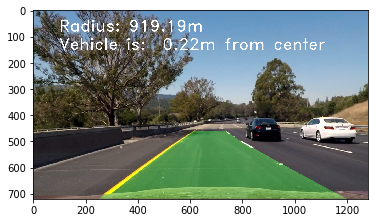

In [92]:
### test code to generate a file image for writeup

img2 = cv2.imread('test_images/'+test_file)
cimage = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

copy_image = np.copy(cimage)
left_line = Line()
right_line = Line()
result = process_image(copy_image, False)
plt.imshow(result)



### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./output_project_video.mp4)

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [76]:
left_line = Line()
right_line = Line()
white_output = 'output_project_video1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,2)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)#.subclip(1,3) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_project_video1.mp4
[MoviePy] Writing video output_project_video1.mp4


100%|█████████▉| 1260/1261 [05:31<00:00,  3.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video1.mp4 

CPU times: user 3min 3s, sys: 23 s, total: 3min 26s
Wall time: 5min 33s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [81]:
challenge_output = 'output_challenge_video1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')#.subclip(0,.5)
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_challenge_video1.mp4
[MoviePy] Writing video output_challenge_video1.mp4


100%|██████████| 485/485 [02:00<00:00,  4.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge_video1.mp4 

CPU times: user 1min 6s, sys: 9.51 s, total: 1min 15s
Wall time: 2min 3s


In [82]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [83]:
left_line = Line()
right_line = Line()
harder_challenge_output = 'output_harder_challenge_video1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

clip3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,2)
harder_challenge_clip = clip3.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video output_harder_challenge_video1.mp4
[MoviePy] Writing video output_harder_challenge_video1.mp4


100%|█████████▉| 1199/1200 [06:22<00:00,  3.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge_video1.mp4 

CPU times: user 3min 23s, sys: 22.3 s, total: 3min 46s
Wall time: 6min 27s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))